## <u>Regridding .nc to N96</u>


July 2019

Import libraries

In [81]:
%load_ext autoreload
%autoreload

import sys
sys.path.append('../')

import warnings
warnings.filterwarnings('ignore')

import os
from   io     import StringIO
import numpy  as np
import pandas as pd
import csv

import iris
import matplotlib.pyplot as plt
import numpy.ma as ma
%matplotlib inline
import cartopy.crs as ccrs
from   libs.plot_maps    import *
from netCDF4 import Dataset

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Set variables

In [34]:
dir = '../data/driving_data2/'

files = {'vegcover'           : 'vegcover2000-2014.nc',
         'alphaMax'           : 'alpha_12monthMax2000-2014.nc',
         'alpha'              : 'alpha2000-2014.nc',
         'emc'                : 'emc2000-2014.nc',
         'treeCover'          : 'treecover2000-2014.nc',
         'lightning'          : 'lightning_ignitions2000-2014.nc',
         'pasture'            : 'pasture2000-2014.nc',
         'population_density' : 'population_density2000-2014.nc',
         'cropland'           : 'cropland2000-2014.nc'}

mask_file = { 'mask':'n96e_orca1_mask.nc'}

In [80]:

print(files.items())
print(mask_file.values())
mask_file["mask"]
print((dir + mask_file['mask']))

dict_items([('vegcover', 'vegcover2000-2014.nc'), ('alphaMax', 'alpha_12monthMax2000-2014.nc'), ('alpha', 'alpha2000-2014.nc'), ('emc', 'emc2000-2014.nc'), ('treeCover', 'treecover2000-2014.nc'), ('lightning', 'lightning_ignitions2000-2014.nc'), ('pasture', 'pasture2000-2014.nc'), ('population_density', 'population_density2000-2014.nc'), ('cropland', 'cropland2000-2014.nc')])
dict_values(['n96e_orca1_mask.nc'])
../data/driving_data2/n96e_orca1_mask.nc


Loading in data

In [36]:
##open data

# files.items shows the name and the file of the entire dictionary. 'key' and 'file' sets the
# name and the file name respectively

input_data = {}
for key, file in files.items(): 
    data = iris.load_cube(dir + file)
    input_data[key] = data

    
# Check it has loaded:
print(input_data['vegcover'])

In [95]:
# This doesn't work because iris.cube_load doesn't understand the file as no caldener time is specified

#data = iris.load(dir + mask_file['mask']) 

# Instead try this:
dataset = Dataset(dir + mask_file['mask'])

# Look at dimensions (lat, lon) and variables (data)
print(dataset.dimensions.keys())
print(dataset.variables.keys())


odict_keys(['longitude', 'latitude', 'surface', 't'])
odict_keys(['longitude', 'latitude', 'surface', 't', 'lsm'])


Extract the data from the netcdf: lsm is the only variable in the dataset

In [87]:
lsm = dataset.variables['lsm'][:]
print(lsm.shape)

dataset.close()

# lsm[0,0,:,:]

(1, 1, 144, 192)

This plots the annual averages of the data, to make sure it looks sane

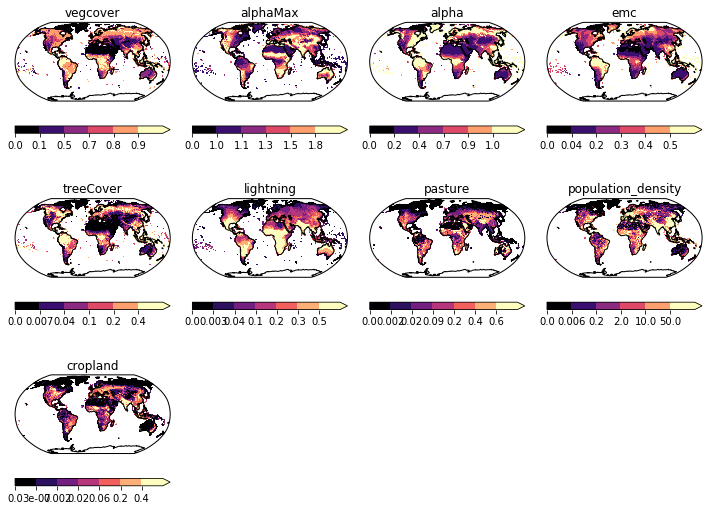

In [92]:
nd = 0

plt.figure(figsize = (10, 7.5))

for key, dat in input_data.items():
    nd = nd + 1
    dat = dat.collapsed('time', iris.analysis.MEAN)
    dat.long_name = key
    plot_lonely_cube(dat, 3, 4, nd, cmap = 'magma', levels = None)    